In [2]:
import sys
print(sys.executable)

/home/013906919/anaconda3/envs/simclr_custom/bin/python


In [1]:
import tensorflow as tf
print(tf.__version__)

2.2.0


In [3]:
!nvidia-smi

Tue Nov 24 20:11:19 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 418.87.00    Driver Version: 418.87.00    CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  On   | 00000000:03:00.0 Off |                    0 |
| N/A   25C    P0    24W / 250W |      0MiB / 12198MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [2]:
from sklearn.preprocessing import LabelEncoder
from sklearn.manifold import TSNE
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
import matplotlib.pyplot as plt
from imutils import paths
from tqdm import tqdm
import tensorflow as tf
import seaborn as sns
import numpy as np
import cv2

In [17]:
# Random seed fixation
tf.random.set_seed(666)
np.random.seed(666)

In [18]:
# Train and test image paths
train_images = list(paths.list_images("Alzheimers_Dataset/train"))
test_images = list(paths.list_images("Alzheimers_Dataset/test"))
print(len(train_images), len(test_images))

5121 1279


In [19]:
def prepare_images(image_paths):
    images = []
    labels = []

    for image in tqdm(image_paths):
        image_pixels = plt.imread(image)
        image_pixels = cv2.cvtColor(image_pixels,cv2.COLOR_GRAY2RGB)
        image_pixels = cv2.resize(image_pixels, (224, 224))
        image_pixels = image_pixels/255.

        label = image.split("/")[2].split("_")[0]

        images.append(image_pixels)
        labels.append(label)

    images = np.array(images)
    labels = np.array(labels)

    print(images.shape, labels.shape)

    return images, labels

In [20]:
X_train, y_train = prepare_images(train_images)
X_test, y_test = prepare_images(test_images)

  3%|▎         | 43/1279 [00:00<00:02, 427.29it/s]

(5121, 224, 224, 3) (5121,)


100%|██████████| 1279/1279 [00:04<00:00, 298.24it/s]


(1279, 224, 224, 3) (1279,)


In [21]:
le = LabelEncoder()
y_train_enc = le.fit_transform(y_train)
y_test_enc = le.transform(y_test)

In [22]:

# Architecture utils
def get_resnet_simclr(hidden_1, hidden_2, hidden_3):
    base_model = tf.keras.applications.ResNet50(include_top=False, weights=None, input_shape=(224, 224, 3))
    base_model.trainable = True
    inputs = Input((224, 224, 3))
    h = base_model(inputs, training=False)
    h = GlobalAveragePooling2D()(h)

    projection_1 = Dense(hidden_1)(h)
    projection_1 = Activation("relu")(projection_1)
    projection_2 = Dense(hidden_2)(projection_1)
    projection_2 = Activation("relu")(projection_2)
    projection_3 = Dense(hidden_3)(projection_2)

    resnet_simclr = Model(inputs, projection_3)

    return resnet_simclr

In [23]:
resnet_simclr = get_resnet_simclr(256, 128, 50)
resnet_simclr.load_weights("20201124-154539resnet_simclr.h5")
resnet_simclr.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
resnet50 (Model)             (None, 7, 7, 2048)        23587712  
_________________________________________________________________
global_average_pooling2d_1 ( (None, 2048)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 256)               524544    
_________________________________________________________________
activation_2 (Activation)    (None, 256)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 128)               32896     
_________________________________________________________________
activation_3 (Activation)    (None, 128)               0   

In [24]:
def plot_training(H):
	with plt.xkcd():
		plt.plot(H.history["loss"], label="train_loss")
		plt.plot(H.history["val_loss"], label="val_loss")
		plt.plot(H.history["accuracy"], label="train_acc")
		plt.plot(H.history["val_accuracy"], label="val_acc")
		plt.title("Training Loss and Accuracy")
		plt.xlabel("Epoch #")
		plt.ylabel("Loss/Accuracy")
		plt.legend(loc="lower left")
		plt.show()

In [25]:
def get_linear_model(features):
    linear_model = Sequential([Dense(5, input_shape=(features, ), activation="softmax")])
    return linear_model

In [26]:
resnet_simclr.layers[1].trainable = False
resnet_simclr.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
resnet50 (Model)             (None, 7, 7, 2048)        23587712  
_________________________________________________________________
global_average_pooling2d_1 ( (None, 2048)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 256)               524544    
_________________________________________________________________
activation_2 (Activation)    (None, 256)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 128)               32896     
_________________________________________________________________
activation_3 (Activation)    (None, 128)               0   

In [27]:
# Encoder model with non-linear projections
projection = Model(resnet_simclr.input, resnet_simclr.layers[-2].output)

# Extract train and test features
train_features = projection.predict(X_train)
test_features = projection.predict(X_test)

print(train_features.shape, test_features.shape)

(5121, 128) (1279, 128)


In [28]:
es = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=2, verbose=2, restore_best_weights=True)

Epoch 1/35
81/81 [==============================] - 0s 5ms/step - loss: 1.5851 - accuracy: 0.4722 - val_loss: 1.3885 - val_accuracy: 0.5027
Epoch 2/35
81/81 [==============================] - 0s 3ms/step - loss: 1.0085 - accuracy: 0.4931 - val_loss: 1.1247 - val_accuracy: 0.5403
Epoch 3/35
81/81 [==============================] - 0s 2ms/step - loss: 0.9690 - accuracy: 0.5062 - val_loss: 1.1073 - val_accuracy: 0.5168
Epoch 4/35
81/81 [==============================] - 0s 3ms/step - loss: 0.9500 - accuracy: 0.5116 - val_loss: 1.0679 - val_accuracy: 0.5387
Epoch 5/35
81/81 [==============================] - 0s 2ms/step - loss: 0.9507 - accuracy: 0.5065 - val_loss: 1.0731 - val_accuracy: 0.5332
Epoch 6/35
81/81 [==============================] - 0s 2ms/step - loss: 0.9459 - accuracy: 0.5104 - val_loss: 1.0659 - val_accuracy: 0.5184
Epoch 7/35
81/81 [==============================] - 0s 2ms/step - loss: 0.9357 - accuracy: 0.5124 - val_loss: 1.0453 - val_accuracy: 0.5152
Epoch 8/35
81/81 [==

findfont: Font family ['xkcd', 'xkcd Script', 'Humor Sans', 'Comic Neue', 'Comic Sans MS'] not found. Falling back to DejaVu Sans.
findfont: Font family ['xkcd', 'xkcd Script', 'Humor Sans', 'Comic Neue', 'Comic Sans MS'] not found. Falling back to DejaVu Sans.


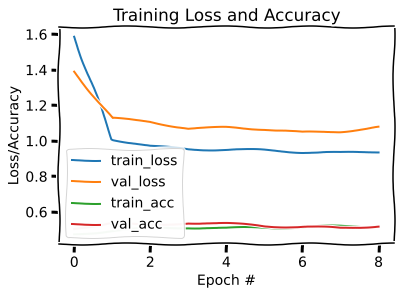

In [30]:
linear_model = get_linear_model(128)
linear_model.compile(loss="sparse_categorical_crossentropy", metrics=["accuracy"],
                     optimizer="adam")
history = linear_model.fit(train_features, y_train_enc,
                 validation_data=(test_features, y_test_enc),
                 batch_size=64,
                 epochs=35,
                 callbacks=[es])
plot_training(history)

In [31]:
projection = Model(resnet_simclr.input, resnet_simclr.layers[-4].output)

# Extract train and test features
train_features = projection.predict(X_train)
test_features = projection.predict(X_test)

print(train_features.shape, test_features.shape)

(5121, 256) (1279, 256)


Epoch 1/35
81/81 [==============================] - 0s 3ms/step - loss: 1.3290 - accuracy: 0.4946 - val_loss: 1.0011 - val_accuracy: 0.5285
Epoch 2/35
81/81 [==============================] - 0s 3ms/step - loss: 0.9599 - accuracy: 0.5136 - val_loss: 0.9713 - val_accuracy: 0.5364
Epoch 3/35
81/81 [==============================] - 0s 2ms/step - loss: 0.9395 - accuracy: 0.5190 - val_loss: 0.9691 - val_accuracy: 0.5356
Epoch 4/35
81/81 [==============================] - 0s 2ms/step - loss: 0.9272 - accuracy: 0.5216 - val_loss: 0.9858 - val_accuracy: 0.5348
Epoch 5/35
81/81 [==============================] - 0s 2ms/step - loss: 0.9392 - accuracy: 0.5138 - val_loss: 1.0298 - val_accuracy: 0.5371
Epoch 00005: early stopping


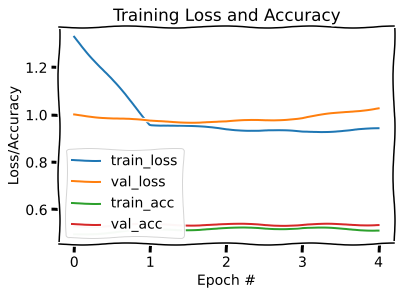

In [32]:
linear_model = get_linear_model(256)
linear_model.compile(loss="sparse_categorical_crossentropy", metrics=["accuracy"],
                     optimizer="adam")
history = linear_model.fit(train_features, y_train_enc,
                 validation_data=(test_features, y_test_enc),
                 batch_size=64,
                 epochs=35,
                 callbacks=[es])
plot_training(history)